If necessary: 
```
conda install -c conda-forge rubin-sim
```
for the work in this notebook, you don't actually need any of the data for download! (i.e. the instructions for [data download](https://rubin-sim.lsst.io/data-download.html#data-download)). 

You will however need the DiscoveryTime metric data, which can be downloaded as a [tarball](https://epyc.astro.washington.edu/~lynnej/opsim_downloads/discovery_time_metrics.tar).


In [83]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import rubin_sim.maf as maf
import rubin_sim.moving_objects as mo
from rubin_sim.data import get_data_dir
from rubin_scheduler.utils import survey_start_mjd

In [4]:
discovery_files = {'MBA': 'baseline_v3_4_10yrs_DiscoveryTime_MBA_3_pairs_in_15_nights_detection_loss_MOOB.npz',
        'NEO': 'baseline_v3_4_10yrs_DiscoveryTime_NEO_3_pairs_in_15_nights_detection_loss_MOOB.npz',
        'OCC_r20': 'baseline_v3_4_10yrs_DiscoveryTime_OCC_r20_3_pairs_in_15_nights_detection_loss_MOOB.npz',
        'OCC_r5': 'baseline_v3_4_10yrs_DiscoveryTime_OCC_r5_3_pairs_in_15_nights_detection_loss_MOOB.npz',
        'PHA': 'baseline_v3_4_10yrs_DiscoveryTime_PHA_3_pairs_in_15_nights_detection_loss_MOOB.npz',
        'TNO': 'baseline_v3_4_10yrs_DiscoveryTime_TNO_3_pairs_in_15_nights_detection_loss_MOOB.npz',
        'Trojan': 'baseline_v3_4_10yrs_DiscoveryTime_Trojan_3_pairs_in_15_nights_detection_loss_MOOB.npz',
        'Vatira': 'baseline_v3_4_10yrs_DiscoveryTime_Vatira_3_pairs_in_15_nights_detection_loss_MOOB.npz'
        }

In [10]:
# map orbit files and object types
objtypes = {
    "granvik_5k": "NEO",
    "granvik_pha_5k": "PHA",
    "vatiras_granvik_10k": "Vatira",
    "l7_5k": "TNO",
    "mba_5k": "MBA",
    "occ_rmax5_5k": "OCC_r5",
    "occ_rmax20_5k": "OCC_r20",
    "sdo_5k": "SDO",
    "trojan_5k": "Trojan",
}

Let's concentrate on the NEOs at the moment, to find the discovery distance of our NEO sample. 

Aiming to determine "median Rubin detection distance" for 30m objects. 

In [131]:
objtype = 'PHA'

# Read the discovery data - "DiscoveryTime" metric outputs tell you the time for first discovery opportunity for 
# each orbit, at each of the H values recorded

bundle = maf.create_empty_mo_metric_bundle()
bundle.read(discovery_files[objtype])

In [132]:
print(bundle.slicer.slice_points.keys())
print(bundle.slicer.slice_points['orbits'][0:10])
print("H values", bundle.slicer.slice_points['H'])

dict_keys(['orbits', 'H'])
          a         e        inc       Omega     argPeri  meanAnomaly  \
0  2.348141  0.575198   9.155245    8.080853  323.708160   132.928696   
1  2.338035  0.642165   7.776101   75.946213  143.485199   348.008698   
2  2.541571  0.689612  13.474915  299.301544  150.045319   323.556824   
3  2.432008  0.577725  21.269661   12.007295  258.309570   210.038162   
4  1.998179  0.810995  16.654800  283.768768   67.535522     9.448424   
5  2.476134  0.679085   8.780108   65.939682   44.205444   207.620392   
6  2.553367  0.602958  39.049370  180.061325  249.812912   110.273201   
7  2.219292  0.546707   4.857623  164.088089  149.143829   153.894394   
8  2.446500  0.679954  21.592586   56.314972  213.416397   293.494171   
9  2.595778  0.629751   7.545134  164.418228  144.487671   133.043823   

     epoch          H   objId     g sed_filename  obj_id  
0  59853.0  24.880890  342446  0.15        S.dat       0  
1  59853.0  24.366861  691142  0.15        S.dat   

In [144]:
# What H value corresponds to the desired size?  Pick closest from slicer (CNEOs page, about H=25)
albedo = 0.14
mag_sun = -26.74
km_per_au = 1.496e8
m_per_km = 1000
H = bundle.slicer.slice_points['H']
diam = 2.0 * np.sqrt(10 ** ((mag_sun - H - 2.5 * np.log10(albedo)) / 2.5)) * km_per_au * m_per_km

diam_desired = 30 
diam_desired = 140 # meters
idx = np.where(np.abs(diam - diam_desired) == np.min(np.abs(diam-diam_desired)))
diam[idx], H[idx]

(array([142.85569926]), array([22.]))

In [145]:
# What fraction of the orbits do we discover at H=25.4
discovery_times = bundle.metric_values[:, idx]
len(discovery_times.compressed()) / len(discovery_times)

0.3916

In [146]:
found_objects = np.where(discovery_times.mask == False)[0]
orbits = bundle.slicer.slice_points['orbits'].iloc[found_objects]
orbits

,a,e,inc,Omega,argPeri,meanAnomaly,epoch,H,objId,g,sed_filename,obj_id
0,2.348141,0.575198,9.155245,8.080853,323.708160,132.928696,59853.0,24.880890,342446,0.15,S.dat,0
12,2.145137,0.564719,15.591998,217.971237,15.258572,306.946533,59853.0,24.331484,771411,0.15,S.dat,12
13,1.188107,0.596884,30.037935,118.799820,191.976959,271.453430,59853.0,24.301641,656202,0.15,S.dat,13
14,1.789663,0.686018,38.152512,92.902283,78.443588,145.783264,59853.0,24.632105,724500,0.15,S.dat,14
15,2.443196,0.686454,15.413498,238.416733,200.023590,331.657898,59853.0,24.769773,228081,0.15,C.dat,15
...,...,...,...,...,...,...,...,...,...,...,...,...
4986,1.465181,0.373183,6.917485,61.547707,340.767639,232.224533,59853.0,24.896462,302563,0.15,S.dat,4986
4987,1.739949,0.648952,1.339769,15.730662,263.209015,156.016815,59853.0,24.531378,601462,0.15,S.dat,4987
4990,1.273416,0.325081,29.505186,48.891724,113.792801,217.372864,59853.0,23.864984,525957,0.15,S.dat,4990
4997,3.708898,0.730553,11.180964,179.662033,141.031937,164.968399,59853.0,24.542541,221843,0.15,C.dat,4997


In [147]:
allorbits = bundle.slicer.slice_points['orbits']

Text(0.4, 0.2, 'Discovered PHAs @ H=25.4:\n 39.16% of sample')

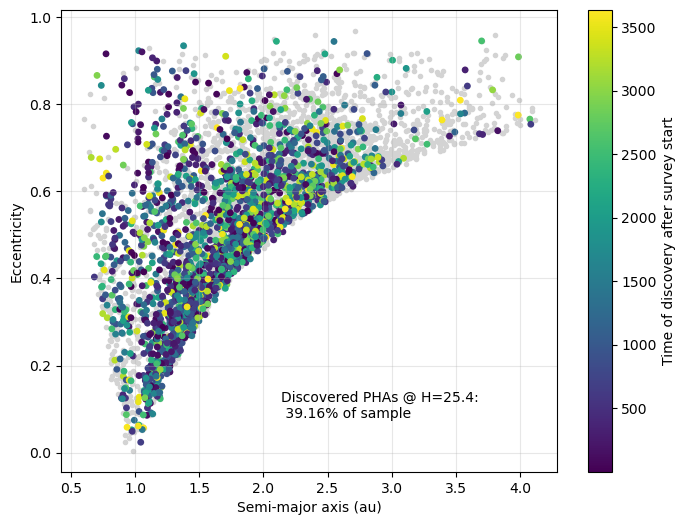

In [149]:
plt.figure(figsize=(8, 6))
plt.plot(allorbits.a, allorbits.e, color='lightgray', linestyle='', marker='.', zorder=0, alpha=1)
plt.scatter(orbits.a, orbits.e, c=discovery_times.compressed()-survey_start_mjd(), s=15, zorder=1)
plt.colorbar(label='Time of discovery after survey start')
plt.xlabel("Semi-major axis (au)")
plt.ylabel("Eccentricity")
plt.grid(True, alpha=0.3)
plt.figtext(0.4, 0.2, f'Discovered {objtype}s @ H=25.4:\n {len(orbits)/len(allorbits) * 100 :0.2f}% of sample')

In [150]:
# Find distance at the discovery time 
# (we could do this in the metrics, but we don't currently ... ah well. 

orb = mo.Orbits()
orb.set_orbits(orbits)

pyeph = mo.PyOrbEphemerides()

In [151]:
# For each orbit, what distance does it have at the time of discovery? 

distances = np.zeros(len(orbits), float)

timescale = 'UTC'
obscode = 'I11'

for i, (oo, time) in enumerate(zip(orb, discovery_times.compressed())):
    pyeph.set_orbits(oo)
    eph = pyeph.generate_ephemerides(time, timescale, obscode)
    distances[i] = eph['geo_dist'][0][0]

In [152]:
# What else would be available?
eph

rec.array([[(63287.02052753, 61.14925019, -65.04591814, 0.66457182, -0.00642464, 78.8122578, 90., 0.98959306, 0.38415363, 23.85140909, 59.33108207, 0.66460288)]],
          dtype=[('time', '<f8'), ('ra', '<f8'), ('dec', '<f8'), ('dradt', '<f8'), ('ddecdt', '<f8'), ('phase', '<f8'), ('solarelon', '<f8'), ('helio_dist', '<f8'), ('geo_dist', '<f8'), ('magV', '<f8'), ('trueAnomaly', '<f8'), ('velocity', '<f8')])

Text(0.5, 0, 'Geocentric Distance at discovery (AU)')

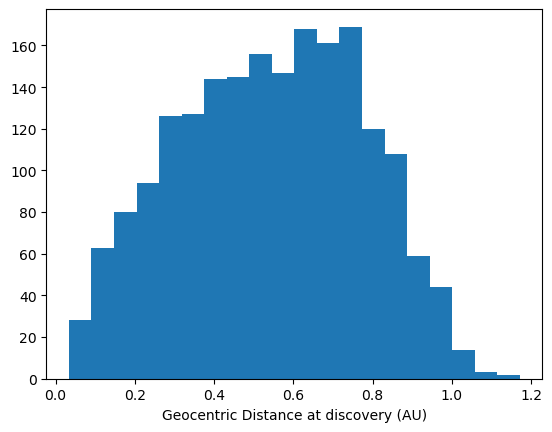

In [153]:
_ = plt.hist(distances, bins=20)
plt.xlabel("Geocentric Distance at discovery (AU)")

In [154]:
distances.mean(), np.median(distances)

(0.5440671307482969, 0.5539295363285599)